In [12]:
import pandas as pd
import numpy as np

In [34]:
# Load True and Fake news datasets
fake_df = pd.read_csv('Fake.csv', encoding='latin-1')
true_df = pd.read_csv('True.csv', encoding='latin-1')


In [14]:
# Add labels
true_df["label"] = 1   # True news = 1
fake_df["label"] = 0   # Fake news = 0

In [15]:
# Merge datasets and shuffle
df = pd.concat([true_df, fake_df], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (44898, 5)


,title,text,subject,date,label
0,Financial adviser sentenced to four years for ...,SAN ANTONIO (Reuters) - A wine industry busine...,politicsNews,"June 28, 2017",1
1,Trumpâs VP Pick Attacked Animated Disney Mo...,"Mike Pence, the presumptive Republican nominee...",News,"July 18, 2016",0
2,Factbox: Trump seen from Davos: 'unbelievable'...,"DAVOS, Switzerland (Reuters) - The surprise em...",politicsNews,"January 21, 2016",1
3,"U.S. bolsters cyber defense for election, few ...",WASHINGTON (Reuters) - Federal and state autho...,politicsNews,"November 4, 2016",1
4,"In Illinois homecoming, Obama calls for improv...","SPRINGFIELD, Ill. (Reuters) - President Barack...",politicsNews,"February 10, 2016",1


Data Cleaning

In [53]:
# Keep only necessary columns
df = df[['content', 'label']]

# Remove duplicates
df.drop_duplicates(subset='content', inplace=True)

# Strip leading/trailing whitespace
df['content'] = df['content'].str.strip()

# Fill missing values
df['content'] = df['content'].fillna('')


In [54]:
# Check for missing values
df.isnull().sum()

content    0
label      0
dtype: int64

In [55]:
print(df.columns)

Index(['content', 'label'], dtype='object')


Exploratory Data Analysis (EDA)

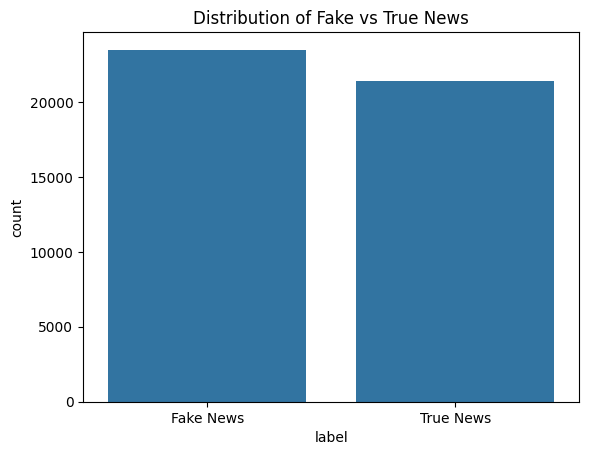

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=df)
plt.xticks([0,1], ['Fake News', 'True News'])
plt.title("Distribution of Fake vs True News")
plt.show()

In [22]:
print("Label percentages:\n", df['label'].value_counts(normalize=True)*100)

Label percentages:
 label
0    52.298543
1    47.701457
Name: proportion, dtype: float64


In [24]:
df['num_words'] = df['content'].apply(lambda x: len(str(x).split()))
df['num_sentences'] = df['content'].apply(lambda x: len(str(x).split('.')))
df['num_characters'] = df['content'].apply(lambda x: len(str(x)))

In [25]:
df[['num_words','num_sentences','num_characters']].describe()


,num_words,num_sentences,num_characters
count,44898.000000,44898.000000,44898.000000
mean,417.806651,22.214976,2559.896009
std,351.562752,18.339206,2177.866659
min,2.000000,1.000000,31.000000
25%,216.000000,11.000000,1324.000000
50%,375.000000,19.000000,2275.000000
75%,526.000000,29.000000,3199.000000
max,8148.000000,556.000000,51897.000000


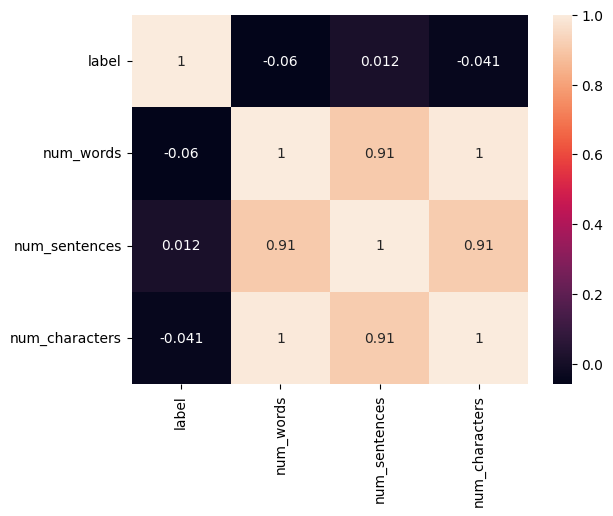

In [26]:
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()


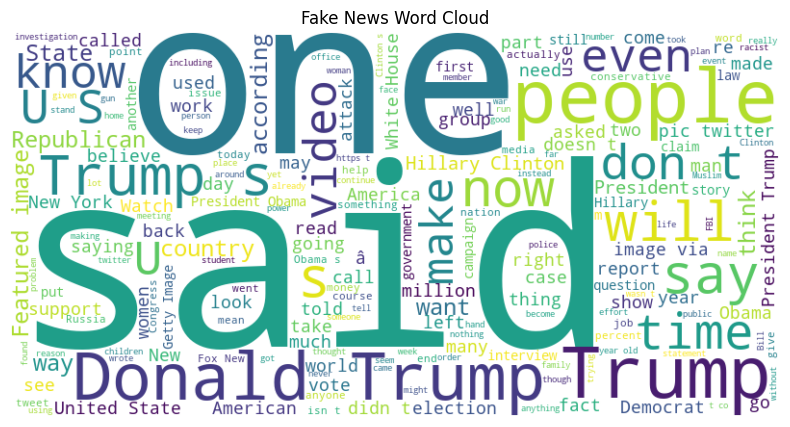

In [28]:
from wordcloud import WordCloud

fake_text = ' '.join(df[df['label'] == 0]['content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News Word Cloud")
plt.show()



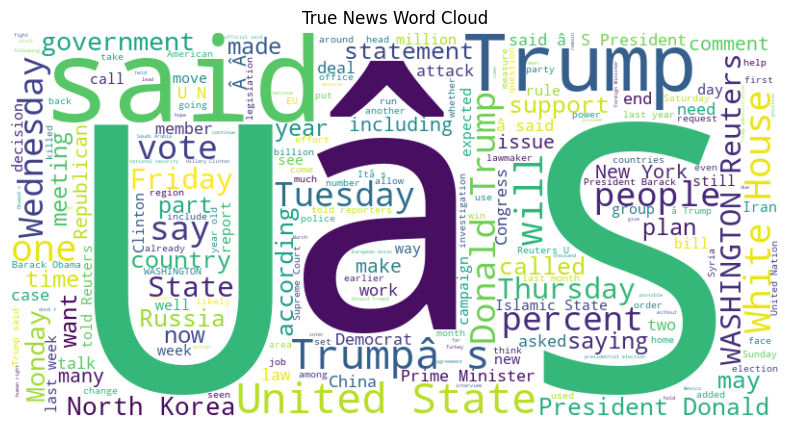

In [29]:
true_text = ' '.join(df[df['label'] == 1]['content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(true_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("True News Word Cloud")
plt.show()



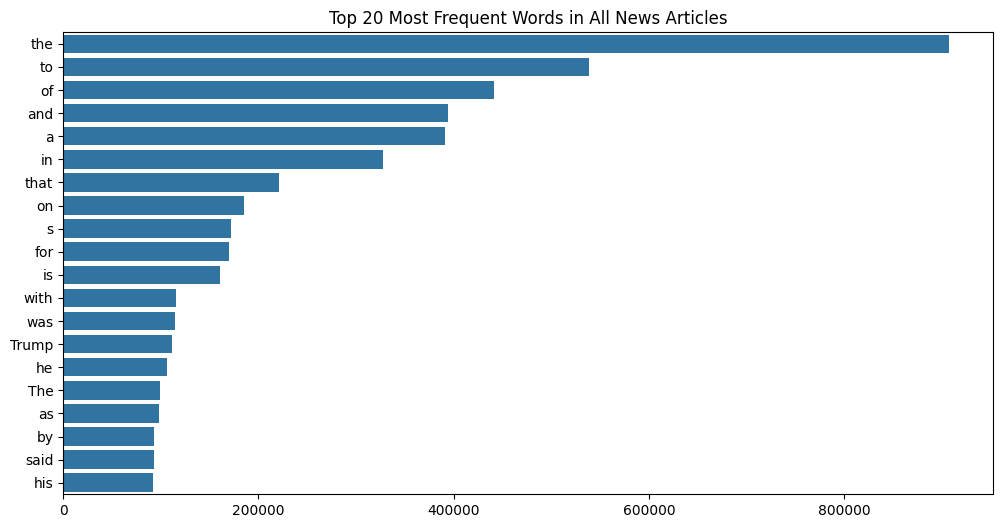

In [31]:
from collections import Counter

all_words = ' '.join(df['content']).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

words = [word for word, freq in most_common_words]
freqs = [freq for word, freq in most_common_words]

plt.figure(figsize=(12,6))
sns.barplot(x=freqs, y=words)
plt.title("Top 20 Most Frequent Words in All News Articles")
plt.show()


Text Preprocessing

In [56]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def transform_text(text):
    text = str(text).lower()                 # Lowercase
    text = nltk.word_tokenize(text)          # Tokenize
    text = [i for i in text if i.isalnum()] # Remove non-alphanumeric
    text = [i for i in text if i not in stop_words]  # Remove stopwords
    text = [ps.stem(i) for i in text]       # Apply stemming
    return " ".join(text)

df['processed_content'] = df['content'].apply(transform_text)
print(df[['content', 'processed_content', 'label']].head())


[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                             content  \
0  Financial adviser sentenced to four years for ...   
1  Trumpâs VP Pick Attacked Animated Disney Mov...   
2  Factbox: Trump seen from Davos: 'unbelievable'...   
3  U.S. bolsters cyber defense for election, few ...   
4  In Illinois homecoming, Obama calls for improv...   

                                   processed_content  label  
0  financi advis sentenc four year bilk nba tim d...      1  
1  vp pick attack anim disney movi mike penc pres...      0  
2  factbox trump seen davo candor vein davo switz...      1  
3  bolster cyber defens elect new step violenc wa...      1  
4  illinoi homecom obama call improv tone polit s...      1  


Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = tfidf.fit_transform(df['processed_content'])
y = df['label']

Train-Test Split

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Model Training and Evaluation

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

clfs = {
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1'),
    'SVC': SVC(kernel='sigmoid', gamma=1.0),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Multinomial NB': MultinomialNB(),
    'Bernoulli NB': BernoulliNB(),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
    'Bagging': BaggingClassifier(n_estimators=50, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='logloss', random_state=42)
}


In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def train_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

In [39]:
results = []
for name, clf in clfs.items():
    metrics = train_evaluate(clf, X_train, y_train, X_test, y_test)
    metrics['Algorithm'] = name
    results.append(metrics)

performance_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False).reset_index(drop=True)
performance_df

c:\Users\somja\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:03:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,Precision,Recall,F1-Score,Confusion Matrix,Algorithm
0,0.997550,0.996274,0.998599,0.997435,"[[4680, 16], [6, 4278]]",XGBoost
1,0.997105,0.996270,0.997666,0.996968,"[[4680, 16], [10, 4274]]",Random Forest
2,0.996548,0.995572,0.997199,0.996385,"[[4677, 19], [12, 4272]]",Bagging
3,0.994543,0.990958,0.997666,0.994300,"[[4657, 39], [10, 4274]]",Decision Tree
4,0.993987,0.989357,0.998133,0.993725,"[[4650, 46], [8, 4276]]",Gradient Boosting
5,0.993653,0.989123,0.997666,0.993376,"[[4649, 47], [10, 4274]]",AdaBoost
6,0.993318,0.990706,0.995331,0.993014,"[[4656, 40], [20, 4264]]",Logistic Regression
7,0.993318,0.991163,0.994865,0.993010,"[[4658, 38], [22, 4262]]",Extra Trees
8,0.985301,0.980556,0.988796,0.984658,"[[4612, 84], [48, 4236]]",SVC
9,0.968151,0.960599,0.973156,0.966837,"[[4525, 171], [115, 4169]]",Bernoulli NB


Visualize F1 Scores

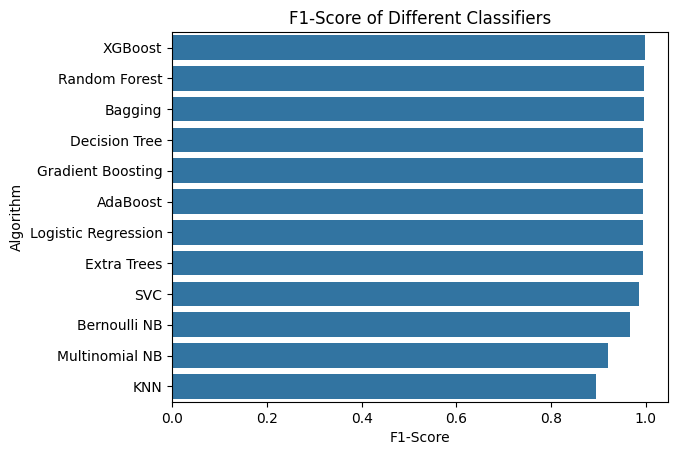

In [40]:
sns.barplot(x='F1-Score', y='Algorithm', data=performance_df)
plt.title("F1-Score of Different Classifiers")
plt.show()

In [63]:
import pickle
import warnings
from xgboost import XGBClassifier

# Ignore XGBoost use_label_encoder warning
warnings.filterwarnings(action='ignore', category=UserWarning, module='xgboost')

best_model_name = performance_df.iloc[0]['Algorithm']
best_model = clfs[best_model_name]
best_model.fit(X, y)  # Train on full dataset

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

with open('best_fake_news_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)


print(f"Best model ({best_model_name}) saved successfully!")


Best model (XGBoost) saved successfully!
